In [1]:
import numpy as np
import xarray as xr 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from datetime import datetime, timedelta, timezone
import glob
import os
import warnings
from matplotlib.lines import Line2D

In [4]:
def wind_direction_difference(dir1, dir2): 
    """
    Calculate the difference in wind direction between two levels,
    handling the 360-degree wrap-around.
    """
    diff = dir2 - dir1
    return (diff + 180) % 360 - 180

def calculate_power_law_exponent(v1, v2, z1, z2):
    """
    Calculates the power law exponent 'alpha'.
    """
    # Ensure no log(0) or division by zero
    v1 = np.where(v1 <= 0, 0.01, v1)
    v2 = np.where(v2 <= 0, 0.01, v2)
    return np.log(v2 / v1) / np.log(z2 / z1)

In [6]:
# --- !! SITE CONFIGURATION !! ---

BARG_DATA_FOLDER = '/Users/mirabel.luo/Documents/AWAKEN/AWAKEN-A1-A2_LiDAR/BARG_Data/' # <-- 1. UPDATE THIS PATH
START_DATE = datetime(2024, 5, 21) # <-- 2. UPDATE THIS
END_DATE = datetime(2024, 9, 30) # <-- 3. UPDATE THIS
BARG_UTC_OFFSET = 5     # <-- 4. UPDATE THIS (e.g., 5 for UTC-5)

print(f"--- BARG Analysis Configuration ---")
print(f"Data Folder: {BARG_DATA_FOLDER}")
print(f"UTC Offset: {BARG_UTC_OFFSET}")
print(f"Analysis Period: {START_DATE.date()} to {END_DATE.date()}")

--- BARG Analysis Configuration ---
Data Folder: /Users/mirabel.luo/Documents/AWAKEN/AWAKEN-A1-A2_LiDAR/BARG_Data/
UTC Offset: 5
Analysis Period: 2024-05-21 to 2024-09-30


In [16]:
def load_lidar_data(file_paths, start_date=None, end_date=None):
    """
    Loads all required Lidar data from netCDF files, applies QC,
    calculates shear/veer, and returns a single pandas DataFrame.
    
    *** UPDATED with correct BARG variable names ***
    """
    all_times, all_veer, all_shear = [], [], []
    if start_date: start_date = pd.to_datetime(start_date, utc=True)
    if end_date: end_date = pd.to_datetime(end_date, utc=True)

    print(f"Loading Lidar data from {len(file_paths)} files...")
    for file_path in file_paths:
        try:
            with xr.open_dataset(file_path) as ds:
                
                # --- START OF VARIABLE NAME FIX ---
                # Try to access all required variables first.
                try:
                    height_var = ds['height'].values
                    times_raw = ds['time'].values
                    
                    # Use the new variable names from your file
                    vhm_raw = ds['wind_speed'].values
                    qc_vhm_raw = ds['qc_wind_speed'].values
                    azim_raw = ds['wind_direction'].values
                    qc_azim_raw = ds['qc_wind_direction'].values
                    
                except KeyError as ke:
                    print(f"Warning: File {os.path.basename(file_path)} is missing a required variable ({ke}). Skipping.")
                    continue 
                # --- END OF VARIABLE NAME FIX ---

                times = pd.to_datetime(times_raw, utc=True)
                
                valid_idx = (times >= start_date) & (times <= end_date)
                if not np.any(valid_idx): continue

                times = times[valid_idx]
                vhm = vhm_raw[valid_idx, :]
                qc_vhm = qc_vhm_raw[valid_idx, :]
                azim = azim_raw[valid_idx, :]
                qc_azim = qc_azim_raw[valid_idx, :]

                # Get height indices
                try:
                    idx_40m = np.where(height_var == 40)[0][0]
                    idx_140m = np.where(height_var == 140)[0][0]
                except IndexError:
                    print(f"Warning: File {os.path.basename(file_path)} does not contain 40m or 140m. Skipping.")
                    continue

                # Get raw data
                wind_direction_40m = azim[:, idx_40m]
                wind_direction_140m = azim[:, idx_140m]
                wind_speed_40m = vhm[:, idx_40m]
                wind_speed_140m = vhm[:, idx_140m]
                
                # Calculate Veer
                height_diff = height_var[idx_140m] - height_var[idx_40m]
                veer_diff = wind_direction_difference(wind_direction_40m, wind_direction_140m)
                wind_veer = veer_diff / height_diff
                
                # Calculate Shear
                wind_shear = calculate_power_law_exponent(wind_speed_40m, wind_speed_140m, 40, 140)
                
                # Apply QC mask (using new variable names)
                valid_mask = (qc_vhm[:, idx_140m] == 0) & (qc_vhm[:, idx_40m] == 0) & \
                             (qc_azim[:, idx_140m] == 0) & (qc_azim[:, idx_40m] == 0) & \
                             (wind_speed_40m > 0) & (wind_speed_140m > 0)
                
                # Append valid data
                all_times.extend(times[valid_mask])
                all_veer.extend(wind_veer[valid_mask])
                all_shear.extend(wind_shear[valid_mask])
        except Exception as e:
            # Catch any other file-opening errors (e.g., corrupt file)
            print(f"Warning: Could not process {os.path.basename(file_path)}. Error: {e}")
            continue

    print("Data loading complete.")
    df_lidar = pd.DataFrame({
        'time': all_times,
        'veer_lidar': all_veer,
        'shear_lidar': all_shear
    })
    return df_lidar.sort_values(by='time').reset_index(drop=True)

# --- Find files and run the loader ---
# (This part is the same as before)
matching_files = sorted(glob.glob(os.path.join(BARG_DATA_FOLDER, '*.nc')))
print(f"Found {len(matching_files)} files in '{BARG_DATA_FOLDER}'")

df_lidar_qc = load_lidar_data(matching_files, START_DATE, END_DATE)
print(f"\nSuccessfully loaded {len(df_lidar_qc)} QC-passed Lidar records.")
print(df_lidar_qc.head())

Found 147 files in 'BARG_Data/'
Loading Lidar data from 147 files...
Data loading complete.

Successfully loaded 15291 QC-passed Lidar records.
                       time  veer_lidar  shear_lidar
0 2024-05-21 19:30:00+00:00      0.0599    -0.045245
1 2024-05-21 19:40:00+00:00      0.0441     0.055157
2 2024-05-21 19:50:00+00:00      0.0600     0.134123
3 2024-05-21 20:00:00+00:00      0.1369     0.171572
4 2024-05-21 20:10:00+00:00     -0.0067     0.039625


In [18]:
def plotDailyAvgWindShearVeer(times, wind_veer, wind_shear, start_date, end_date):
    """
    Plots daily average wind veer, shear, and data availability.
    (This is the final 3-axis version from your C1A notebook with all bug fixes)
    """
    if not (len(times) == len(wind_veer) == len(wind_shear)):
        if len(times) == 0:
            print("No data for this period. Skipping plot.")
            return
        raise ValueError("The lengths of 'times', 'wind_veer', and 'wind_shear' must be the same.")

    times = pd.to_datetime(times)
    if times.tzinfo is None: times = times.tz_localize('UTC')
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    if start_date.tzinfo is None: start_date = start_date.tz_localize('UTC')
    if end_date.tzinfo is None: end_date = end_date.tz_localize('UTC')

    df = pd.DataFrame({'time': times, 'wind_veer': wind_veer, 'wind_shear': wind_shear})
    df = df[(df['time'] >= start_date) & (df['time'] <= end_date)]
    
    # Check if df is empty after filtering
    if df.empty:
        print(f"No data for {start_date.date()} to {end_date.date()}. Skipping plot.")
        return

    df['time_of_day'] = df['time'].dt.strftime('%H:%M')
    all_times = pd.date_range('00:00', '23:59', freq='h').strftime('%H:%M')

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        daily_avg_veer = df.groupby('time_of_day')['wind_veer'].median().reindex(all_times, fill_value=np.nan)
        daily_std_veer = df.groupby('time_of_day')['wind_veer'].std().reindex(all_times, fill_value=np.nan)
        daily_avg_shear = df.groupby('time_of_day')['wind_shear'].median().reindex(all_times, fill_value=np.nan)
        daily_std_shear = df.groupby('time_of_day')['wind_shear'].std().reindex(all_times, fill_value=np.nan)

    plot_max_veer = daily_avg_veer.notna().any()
    plot_max_shear = daily_avg_shear.notna().any()
    max_veer_value, max_veer_time_str, max_veer_time_idx = np.nan, None, None
    max_shear_value, max_shear_time_str, max_shear_time_idx = np.nan, None, None

    if plot_max_veer:
        max_veer_value = daily_avg_veer.max()
        max_veer_time_str = daily_avg_veer.idxmax()
        max_veer_time_idx = daily_avg_veer.index.get_loc(max_veer_time_str)
        print(f"Maximum Wind Veer: {max_veer_value:.3f} deg/m at {max_veer_time_str}")
    else:
        print("No valid Wind Veer data for this period.")

    if plot_max_shear:
        max_shear_value = daily_avg_shear.max()
        max_shear_time_str = daily_avg_shear.idxmax()
        max_shear_time_idx = daily_avg_shear.index.get_loc(max_shear_time_str)
        print(f"Maximum Wind Shear: {max_shear_value:.3f} m/s/m at {max_shear_time_str}")
    else:
        print("No valid Wind Shear data for this period.")
        
    fig, ax1 = plt.subplots(figsize=(12, 6))
    shift_value = 0.1
    ax1.errorbar(daily_avg_veer.index, daily_avg_veer.values, yerr=daily_std_veer.values, fmt='o', color='blue', alpha=0.7, elinewidth=2, label="_nolegend_", zorder=1)
    veer_line, = ax1.plot(daily_avg_veer.index, daily_avg_veer.values, color='blue', linestyle='--', label='Wind Veer (deg/m)', zorder=1)
    
    ax2 = ax1.twinx()
    shifted_x_shear = np.array(range(len(daily_avg_shear.index))) + shift_value
    ax2.errorbar(shifted_x_shear, daily_avg_shear.values, yerr=daily_std_shear.values, fmt='o', color='green', alpha=0.7, elinewidth=2, label="_nolegend_", zorder=1)
    shear_line, = ax2.plot(shifted_x_shear, daily_avg_shear.values, color='green', linestyle='-', label='Wind Shear (m/s/m)', zorder=1)

    if plot_max_veer:
        ax1.scatter(max_veer_time_idx, max_veer_value, color='purple', zorder=2, label='Max Veer')
        ax1.axvline(x=max_veer_time_idx, color='purple', linestyle='--', label='_nolegend_', zorder=3)

    if plot_max_shear:
        shifted_max_shear_idx = max_shear_time_idx + shift_value
        ax2.scatter(shifted_max_shear_idx, max_shear_value, color='orange', zorder=2, label='Max Shear')
        ax2.axvline(x=shifted_max_shear_idx, color='orange', linestyle='--', label='_nolegend_', zorder=3)

    ax1.set_xticks(np.arange(len(all_times)))
    ax1.set_xticklabels(all_times, rotation=45)
    ax1.set_xlabel('Time of Day (UTC)'); ax1.set_ylabel('Wind Veer (deg/m)', color='black')
    ax1.tick_params(axis='y', labelcolor='black')
    ax2.set_ylabel('Wind Shear (m/s/m)', color='black')
    ax2.tick_params(axis='y', labelcolor='black')
    
    ax1.set_title(f'Site BARG Daily Average Wind Veer and Wind Shear from {start_date.date()} to {end_date.date()}\n'
                  f'Hub Height: 40 m to 140 m')

    max_veer_proxy = Line2D([0], [0], marker='o', color='purple', linestyle='None', markersize=8)
    max_shear_proxy = Line2D([0], [0], marker='o', color='orange', linestyle='None', markersize=8)
    lines = [veer_line, shear_line]; labels = ['Wind Veer', 'Wind Shear']
    ax1.legend(lines, labels, loc='upper left')
    ax2.legend(handles=[max_veer_proxy, max_shear_proxy], labels=['Max Veer', 'Max Shear'], loc='upper right')

    ax3 = ax1.twinx(); ax3.spines['right'].set_position(('outward', 60))
    ax3.set_ylabel('Data Percentage Available', color='gray'); ax3.tick_params(axis='y', labelcolor='gray')
    
    total_data_points = (end_date - start_date).days + 1
    hourly_counts = df.groupby('time_of_day').size().reindex(all_times, fill_value=0)
    hourly_percentage = (hourly_counts / total_data_points) * 100
    ax3.bar(all_times, hourly_percentage, color='lightgray', alpha=0.5, label='Data Percentage', width=1.0, zorder=-2)
    ax3.set_yticks(np.arange(0, 101, 10)); ax3.set_yticklabels([f"{tick}%" for tick in np.arange(0, 101, 10)])

    plt.tight_layout()
    plt.show()

--- Generating BARG Daily Monthly Averages ---
--- Using QC-passed df_lidar_qc data ---

 JUNE 2024
Maximum Wind Veer: 0.113 deg/m at 08:00
Maximum Wind Shear: 0.424 m/s/m at 09:00


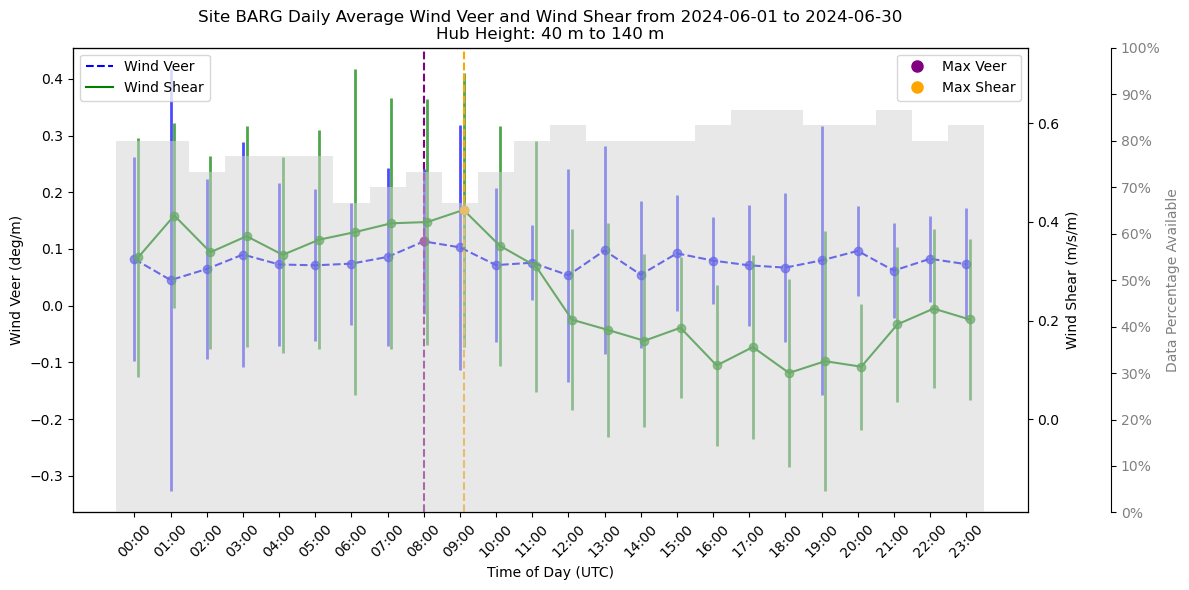


 JULY 2024
Maximum Wind Veer: 0.150 deg/m at 13:00
Maximum Wind Shear: 0.225 m/s/m at 02:00


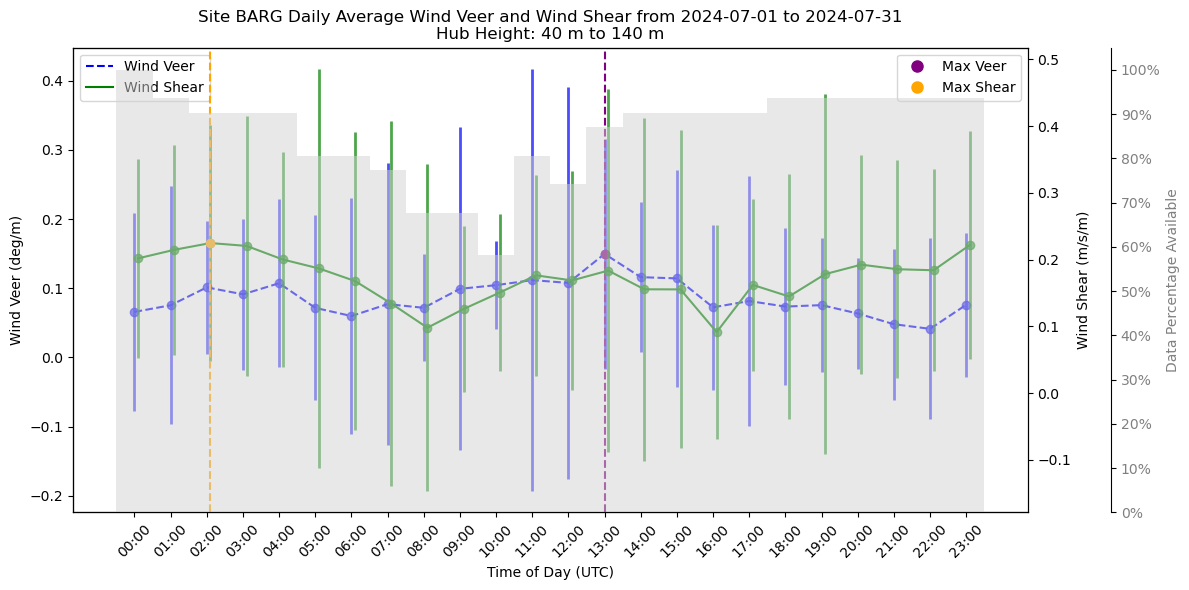


 AUGUST 2024
Maximum Wind Veer: 0.119 deg/m at 09:00
Maximum Wind Shear: 0.258 m/s/m at 03:00


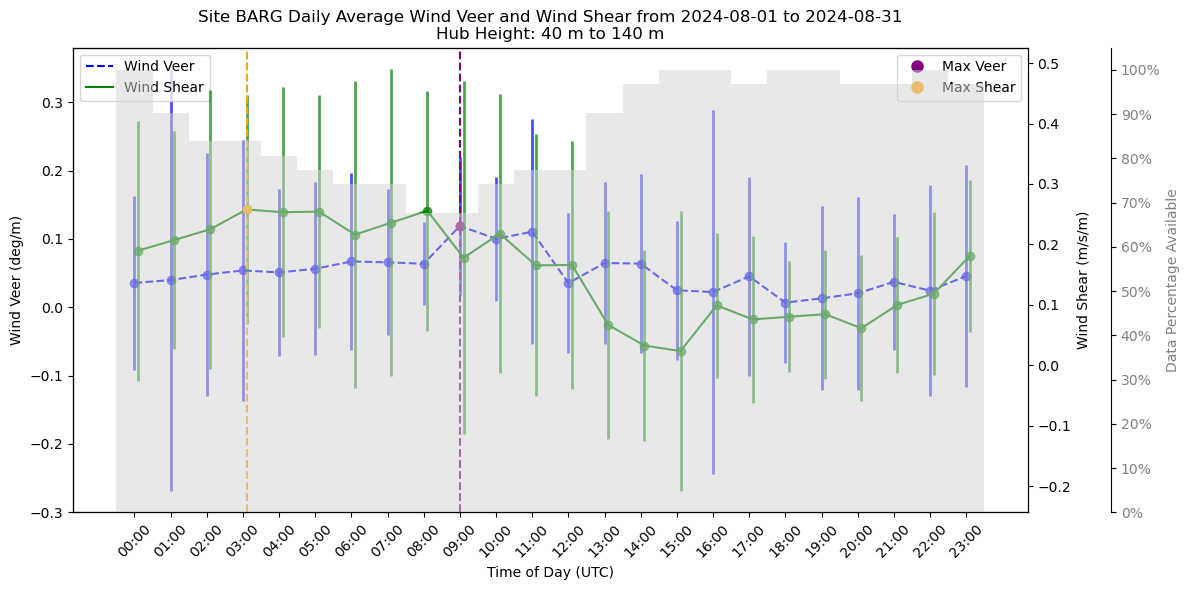


 SEPTEMBER 2024
Maximum Wind Veer: 0.033 deg/m at 16:00
Maximum Wind Shear: 0.090 m/s/m at 01:00


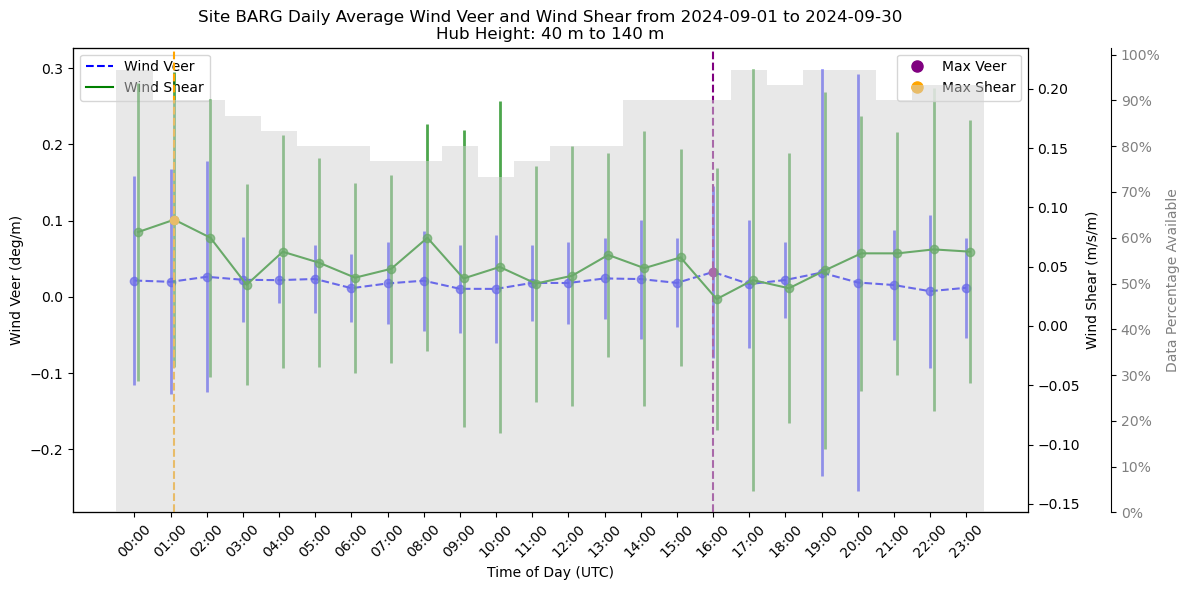

In [20]:
print("--- Generating BARG Daily Monthly Averages ---")
print("--- Using QC-passed df_lidar_qc data ---")

if not df_lidar_qc.empty:
    months = pd.date_range(START_DATE, END_DATE, freq='MS')
    
    for month_start in months:
        start_date_utc = month_start.to_pydatetime().replace(tzinfo=timezone.utc)
        
        # Get end of month
        if month_start.month == 12:
            end_date_utc = datetime(month_start.year + 1, 1, 1, tzinfo=timezone.utc) - timedelta(seconds=1)
        else:
            end_date_utc = datetime(month_start.year, month_start.month + 1, 1, tzinfo=timezone.utc) - timedelta(seconds=1)

        print(f"\n", month_start.strftime('%B %Y').upper())
        
        # We can just pass the full, clean lists
        # The plotting function will handle the monthly filtering
        times = df_lidar_qc['time'].values
        wind_veer = df_lidar_qc['veer_lidar'].values
        wind_shear = df_lidar_qc['shear_lidar'].values
        
        plotDailyAvgWindShearVeer(times, wind_veer, wind_shear, start_date_utc, end_date_utc)
else:
    print("df_lidar_qc is empty. Skipping monthly plots.")

In [34]:
def generate_monthly_heatmap_data(df, year, month):
    """
    Generates monthly-averaged veer and shear DataFrames for the heatmap
    from the main QC-passed DataFrame.
    """
    start_date = pd.to_datetime(f"{year}-{month}-01", utc=True)
    if month == 12:
        end_date = pd.to_datetime(f"{year+1}-01-01", utc=True) - pd.Timedelta(seconds=1)
    else:
        end_date = pd.to_datetime(f"{year}-{month+1}-01", utc=True) - pd.Timedelta(seconds=1)

    df_month = df[(df['time'] >= start_date) & (df['time'] <= end_date)].copy()
    all_times = pd.date_range('00:00', '23:59', freq='h').strftime('%H:%M')

    if df_month.empty:
        print(f"No clean data for {year}-{month:02d}, returning empty DataFrames.")
        empty_series_veer = pd.Series(index=all_times, dtype=float, name='average_wind_veer').rename_axis('time_of_day')
        empty_series_shear = pd.Series(index=all_times, dtype=float, name='average_wind_shear').rename_axis('time_of_day')
        return empty_series_veer.reset_index(), empty_series_shear.reset_index()

    df_month['time_of_day'] = df_month['time'].dt.strftime('%H:%M')
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        avg_veer = df_month.groupby('time_of_day')['veer_lidar'].median().reindex(all_times, fill_value=np.nan)
        avg_shear = df_month.groupby('time_of_day')['shear_lidar'].median().reindex(all_times, fill_value=np.nan)

    avg_veer.name = 'average_wind_veer'
    avg_shear.name = 'average_wind_shear'
    avg_veer.index.name = 'time_of_day'
    avg_shear.index.name = 'time_of_day'
    
    return avg_veer.reset_index(), avg_shear.reset_index()

def prepare_heatmap_data(dataframes, value_col, utc_offset_hours=0):
    heatmap_matrix = []
    for df in dataframes:
        hours_array = np.full(24, np.nan)
        for hour_str, val in zip(df['time_of_day'], df[value_col]):
            if isinstance(hour_str, str) and pd.notna(val):
                utc_hour = int(hour_str.split(':')[0])
                local_hour = (utc_hour - utc_offset_hours) % 24
                hours_array[local_hour] = val
        heatmap_matrix.append(hours_array)
    return np.array(heatmap_matrix)

# === Heatmap Plotter (3-Hour Labels, No Rotation) ===
def plot_heatmap(matrix, labels, title, xlabel, ylabel, time_labels, 
                 colorbar_label, vmin, vmax, cmap, utc_offset_hours=None):
    
    # Give it a little less extra height, as horizontal labels are shorter
    plt.figure(figsize=(12, 0.6 * len(labels) + 3)) 
    ax = plt.gca() 
    
    im = ax.imshow(matrix, aspect='auto', cmap=cmap, origin='upper',
                     vmin=vmin, vmax=vmax)
    plt.colorbar(im, label=colorbar_label)

    # --- Primary X-Axis (Local Time) ---
    
    all_ticks = np.arange(len(time_labels))
    all_labels = time_labels
    
    ax.set_xticks(ticks=np.arange(len(time_labels)), labels=time_labels, rotation=45)
    ax.set_xlabel('Local Time')
    

    # --- Y-Axis ---
    ax.set_yticks(ticks=np.arange(len(labels)), labels=labels)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

    # --- Secondary X-Axis (UTC Time) ---
    if utc_offset_hours is not None:
        all_utc_labels = [f"{(h + utc_offset_hours) % 24:02d}:00" for h in range(24)]
        
        ax2 = ax.secondary_xaxis('bottom')
        
        # --- FIX: Show every 3rd label, no rotation ---
        ax2.set_xticks(
            ticks=all_ticks[::3],  # Use every 3rd tick
            labels=all_utc_labels[::3] # Use every 3rd label
            # No rotation or ha needed
        )
        
        # Adjust spacing for non-rotated labels
        ax2.spines['bottom'].set_position(('outward', 50)) 
        ax2.set_xlabel('UTC Time')
        
        # Reduce bottom padding
        plt.subplots_adjust(bottom=0.2) 
    else:
        plt.tight_layout()

    plt.show()

--- Generating BARG Heatmap Data (June-Sept) ---
Generating heatmap data for 2024-05
Generating heatmap data for 2024-06
Generating heatmap data for 2024-07
Generating heatmap data for 2024-08
Generating heatmap data for 2024-09
No clean data for 2000-01, returning empty DataFrames.
No clean data for 2000-01, returning empty DataFrames.
No clean data for 2000-01, returning empty DataFrames.
No clean data for 2000-01, returning empty DataFrames.
No clean data for 2000-01, returning empty DataFrames.
No clean data for 2000-01, returning empty DataFrames.
No clean data for 2000-01, returning empty DataFrames.
No clean data for 2000-01, returning empty DataFrames.
No clean data for 2000-01, returning empty DataFrames.
No clean data for 2000-01, returning empty DataFrames.
No clean data for 2000-01, returning empty DataFrames.
No clean data for 2000-01, returning empty DataFrames.
No clean data for 2000-01, returning empty DataFrames.
No clean data for 2000-01, returning empty DataFrames.



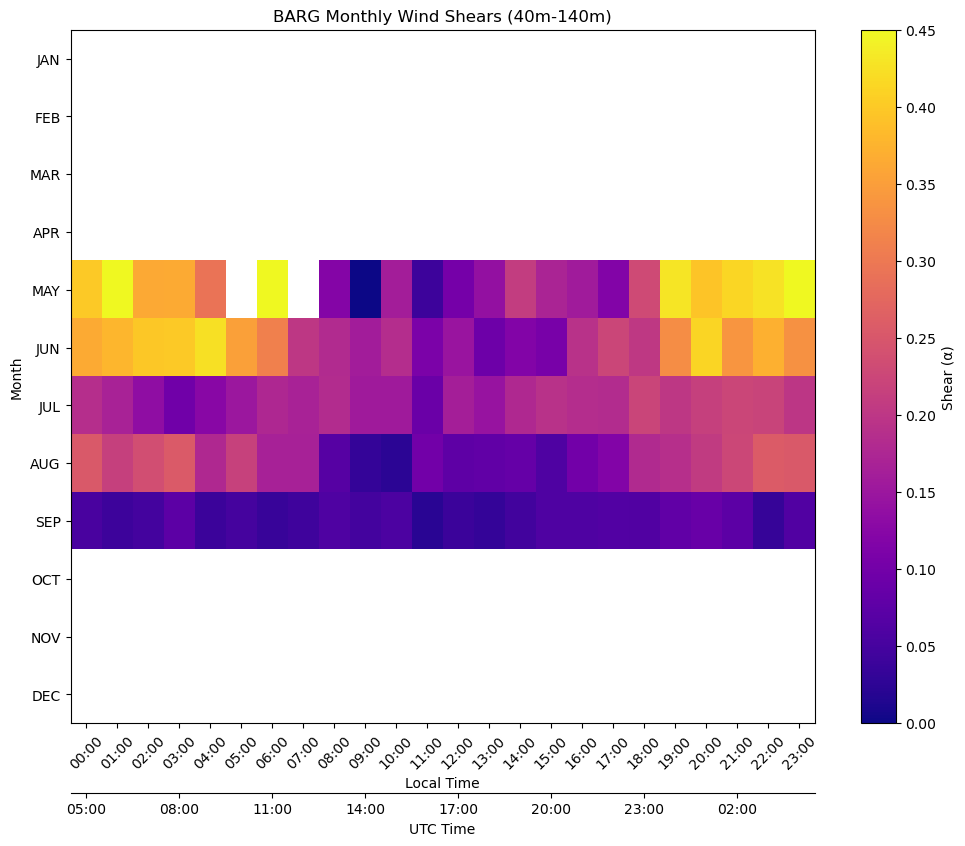

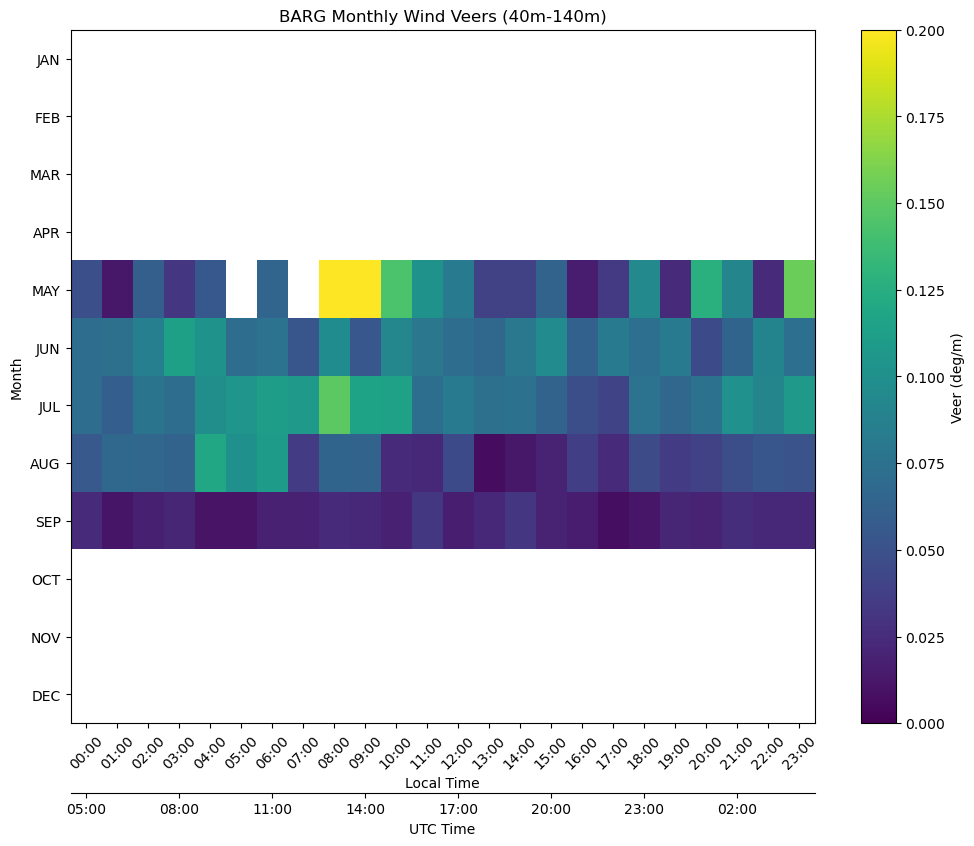

In [42]:
print("--- Generating BARG Heatmap Data (June-Sept) ---")

barg_veer_data = {}
barg_shear_data = {}

# --- START OF MODIFICATION ---
months_to_plot = [1,2,3,4,5,6, 7, 8, 9,10,11,12]
barg_labels = ['JAN','FEB','MAR', 'APR','MAY','JUN', 'JUL', 'AUG', 'SEP','OCT','NOV','DEC']
# --- END OF MODIFICATION ---

if not df_lidar_qc.empty:
    min_date = df_lidar_qc['time'].min()
    max_date = df_lidar_qc['time'].max()
    
    years = range(min_date.year, max_date.year + 1)
    
    # 1. Generate all monthly dataframes (for the months we care about)
    for year in years:
        for month in months_to_plot: # Only loop over JUN-SEP
            if (datetime(year, month, 1, tzinfo=timezone.utc) <= max_date) and \
               (datetime(year, month, 1, tzinfo=timezone.utc) + pd.offsets.MonthEnd(1) >= min_date):
                
                print(f"Generating heatmap data for {year}-{month:02d}")
                df_v, df_s = generate_monthly_heatmap_data(df_lidar_qc, year, month)
                barg_veer_data[(year, month)] = df_v
                barg_shear_data[(year, month)] = df_s

    # 2. Create the final month lists, averaging where multiple years exist
    barg_veer_dfs = []
    barg_shear_dfs = []
    time_labels = [f"{h:02d}:00" for h in range(24)] # for plot x-axis

    for month_num in months_to_plot: # Only loop over JUN-SEP
        veer_dfs_for_month = [df for (y, m), df in barg_veer_data.items() if m == month_num]
        shear_dfs_for_month = [df for (y, m), df in barg_shear_data.items() if m == month_num]

        # --- Average Veer for the month ---
        if len(veer_dfs_for_month) > 1:
            merged_veer = pd.merge(veer_dfs_for_month[0], veer_dfs_for_month[1], on='time_of_day', suffixes=('_1', '_2'), how='outer')
            merged_veer['average_wind_veer'] = merged_veer[['average_wind_veer_1', 'average_wind_veer_2']].mean(axis=1, skipna=True)
            barg_veer_dfs.append(merged_veer)
        elif len(veer_dfs_for_month) == 1:
            barg_veer_dfs.append(veer_dfs_for_month[0])
        else:
            # Append empty df if no data for this month
            df_v, _ = generate_monthly_heatmap_data(df_lidar_qc, 2000, 1) # Get empty template
            barg_veer_dfs.append(df_v)
        
        # --- Average Shear for the month ---
        if len(shear_dfs_for_month) > 1:
            merged_shear = pd.merge(shear_dfs_for_month[0], shear_dfs_for_month[1], on='time_of_day', suffixes=('_1', '_2'), how='outer')
            merged_shear['average_wind_shear'] = merged_shear[['average_wind_shear_1', 'average_wind_shear_2']].mean(axis=1, skipna=True)
            barg_shear_dfs.append(merged_shear)
        elif len(shear_dfs_for_month) == 1:
            barg_shear_dfs.append(shear_dfs_for_month[0])
        else:
            _, df_s = generate_monthly_heatmap_data(df_lidar_qc, 2000, 1) # Get empty template
            barg_shear_dfs.append(df_s)
            
    # 3. Create the heatmap matrices
    print("\nCreating heatmap matrices...")
    barg_shear_matrix = prepare_heatmap_data(barg_shear_dfs, value_col='average_wind_shear', utc_offset_hours=BARG_UTC_OFFSET)
    barg_veer_matrix = prepare_heatmap_data(barg_veer_dfs, value_col='average_wind_veer', utc_offset_hours=BARG_UTC_OFFSET)

    # 4. Plot Heatmaps
    print("Plotting heatmaps...")
    
    # BARG — Shear
    plot_heatmap(barg_shear_matrix, barg_labels, # barg_labels is now ['JUN', 'JUL', 'AUG', 'SEP']
                 title="BARG Monthly Wind Shears (40m-140m)", xlabel="Local Time", ylabel="Month",
                 time_labels=time_labels, colorbar_label="Shear (α)", 
                 vmin=0, vmax=0.45, cmap='plasma', utc_offset_hours=BARG_UTC_OFFSET)

    # BARG — Veer
    plot_heatmap(barg_veer_matrix, barg_labels, # barg_labels is now ['JUN', 'JUL', 'AUG', 'SEP']
                 title="BARG Monthly Wind Veers (40m-140m)", xlabel="Local Time", ylabel="Month",
                 time_labels=time_labels, colorbar_label="Veer (deg/m)", 
                 vmin=0, vmax=0.2, cmap='viridis', utc_offset_hours=BARG_UTC_OFFSET)

else:
    print("df_lidar_qc is empty. Skipping heatmap generation.")